In [4]:
import torch 
from torch.utils import data # 获取迭代数据
from torch.autograd import Variable # 获取变量
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import pandas as pd
import numpy as np
import os 
from sklearn.model_selection import train_test_split
import copy
import matplotlib.pyplot as plt
import random
import math
import torch.nn.functional as F
import sklearn.cluster as sc



c:\Users\py\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#读入文件
# file_path = r'people-gait\room1\1\fixed_route\77Ghz_radar'
# file_path = r'room1\1\fixed_route\77Ghz_radar'
file_path = r'room1\1\free_route\77Ghz_radar'
csv_all = os.listdir(file_path)
#设置超参数
frame_size = 32 #每个样本的帧大小
frame_stride = 30 #滑动窗口步长
batch_size = 32 
people_count = len(csv_all)  #志愿者个数
# people_count = 10
points_frame = 64
print(people_count)

23


In [6]:
'''
数据预处理
1.DBSCAN聚类算法
2.匈牙利算法解决步态数据追踪的问题
'''


# 计算两个点之间的欧式距离，参数为两个元组
def dist(t1, t2):
    dis = math.sqrt( (np.power((t1[0]-t2[0]),2) + np.power((t1[1]-t2[1]),2) + np.power((t1[2]-t2[2]),2)) )
    return dis

def dist2(t1,t2):
    return abs(t1[0]-t2[0]) < 0.75 and abs(t1[1]-t2[1]) < 0.75 and abs(t1[2]-t2[2]) < 1

def dbscan(Data, Eps, MinPts):
    num = len(Data)  # 点的个数
    # print("点的个数："+str(num))
    unvisited = [i for i in range(num)]  # 没有访问到的点的列表
    # print(unvisited)
    visited = []  # 已经访问的点的列表
    C = [-1 for i in range(num)]
    # C为输出结果，默认是一个长度为num的值全为-1的列表
    # 用k来标记不同的簇，k = -1表示噪声点
    k = -1
    # 如果还有没访问的点
    while len(unvisited) > 0:
        # 随机选择一个unvisited对象
        p = random.choice(unvisited)
        unvisited.remove(p)
        visited.append(p)
        # N为p的epsilon邻域中的对象的集合
        N = []
        for i in range(num):
            if (dist(Data[i], Data[p]) <= Eps):# and (i!=p):
                N.append(i)
        # 如果p的epsilon邻域中的对象数大于指定阈值，说明p是一个核心对象
        if len(N) >= MinPts:
            k = k+1
            # print(k)
            C[p] = k
            # 对于p的epsilon邻域中的每个对象pi
            for pi in N:
                if pi in unvisited:
                    unvisited.remove(pi)
                    visited.append(pi)
                    # 找到pi的邻域中的核心对象，将这些对象放入N中
                    # M是位于pi的邻域中的点的列表
                    M = []
                    for j in range(num):
                        if (dist(Data[j], Data[pi])<=Eps): #and (j!=pi):
                            M.append(j)
                    if len(M)>=MinPts:
                        for t in M:
                            if t not in N:
                                N.append(t)
                # 若pi不属于任何簇，C[pi] == -1说明C中第pi个值没有改动
                if C[pi] == -1:
                    C[pi] = k
        # 如果p的epsilon邻域中的对象数小于指定阈值，说明p是一个噪声点
        else:
            C[p] = -1
    
    #长方体去噪
    NN = 0 #存储方框内点的个数的最大值
    ii = 0 #记录中心点
    for i in range(num):
        MM = 0 #存储当前点方框内点的个数
        if C[p] != -1:
            for j in range(num):
                if dist2(Data[i],Data[j]):
                    MM+=1
        if NN < MM:
            ii = i
            NN = MM
    for i in range(num):
        if not dist2(Data[i],Data[ii]):
            C[p] = -1
#     print(NN,ii)
    return C

In [7]:
'''
上采样
'''

people_num = []  #志愿者编号
X = []
label = np.zeros(people_count,dtype = float)
Y = []
n = 0
for info in csv_all: 
    domain = os.path.abspath(file_path) #获取文件夹的路径 
    path = os.path.join(domain,info) #将路径与文件名结合起来就是每个文件的完整路径 
    people_num.append(info[0:3])
    data = pd.read_csv(path)
    data = data.drop( columns=['y','m','d','h','m.1','s'])
    
    #DBSCAN聚类
    i = 0
    Cs = []
    while i < data.shape[0]:
#         print(i)
        frame_code = int(data.loc[i][0])
        frame = []
        while(frame_code == int(data.loc[i][0]) ):
            frame.append( [data.loc[i][2],data.loc[i][3],data.loc[i][4] ] )
            i+=1
            if(i >= len(data)):
                break
#         db = sc.DBSCAN(eps=0.3, min_samples=7).fit(frame)
#         Cs+=db.labels_.tolist()
        
        C = dbscan(Data = frame, Eps = 0.3, MinPts = 7)
        
#         print(C)
        Cs+=C

    #方框去噪点，量纲有问题

    i = 0
    label[n] = 1
    print(label)
    
    while i < data.shape[0]:
        pic = []
        for _ in range(frame_size):
            if i >= data.shape[0]:
                break
            objs=[]
            if Cs[i] != -1:
                objs.append(data.loc[i])
            i+=1

            #将同一帧的点云数据提取出来
            while i < data.shape[0] and data.loc[i-1][0] == data.loc[i][0] :
                if Cs[i] != -1:
                    objs.append(data.loc[i])
                i += 1
            #初步想法，将i减去回到原来的位置,用一个大小为30的数组将每一次多加的给存起来，或者用一个变量存
            if (len(objs)) == 0 or len(objs) < 16:
                break
            #不足则填充
#             print(len(objs))
            while len(objs) < points_frame:
                
                objs = objs+objs
            objs = objs[:points_frame]
            pic.append(objs)
            
        if len(pic) == frame_size:
            pic = np.array(pic)
            pic = pic[:,:,2:7]
            pic = pic.tolist()
            X.append(pic)
            Y.append(copy.deepcopy(label))
    label[n] = 0
#     print(np.array(Y).shape)
#     print(np.array(X).shape)
    n+=1
    if n == people_count:
        break

    print(len(X))


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
12
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
12
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
28
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
37
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
54
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
73
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
84
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
87
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
95
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
100
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
109
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
129
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [8]:
print(np.array(X).shape)
print(np.array(Y).shape)

Y = list(np.float_(Y))

print(type(X)) # (248, 32, 64, 5) -> (样本数？， 32帧， 64个点，5个属性)

(248, 32, 64, 5)
(248, 23)
<class 'list'>


In [9]:
'''
缺失值处理
'''
for i in range(len(X)):
    for j in range(30):
        for k in range(points_frame): 
            if X[i][j][k][3] > 10 or X[i][j][k][3] < -10 or np.isnan(X[i][j][k][3]):
                X[i][j][k][3] = 0


In [10]:
X = np.array(X)
print(np.argwhere(np.isnan(X)))

[]


In [11]:

X_train ,X_test,Y_train,Y_test =train_test_split(X,Y,test_size= 0.2,shuffle=True,random_state =None)  # 设置测试集百分比 !!!!!!!!!!!!!数据集划分
X_train, Y_train = torch.FloatTensor(X_train),torch.FloatTensor(Y_train)     #训练集的输入： tensor浮点数 训练集的输出： tensor 整数
X_test,  Y_test= torch.FloatTensor(X_test),torch.FloatTensor(Y_test)         #测试集的输入： tensor浮点数 测试集的输出： tensor 整数


train_dataset =  torch.utils.data.TensorDataset(X_train,Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test,Y_test)

train_loader = torch.utils.data.DataLoader(dataset =train_dataset ,batch_size = 32,shuffle =True)  # 设置每次训练的数据的数目：batch_size =400
test_loader = torch.utils.data.DataLoader(dataset =test_dataset ,batch_size = 32,shuffle =True)

C:\Users\py\AppData\Local\Temp\ipykernel_31804\2650079026.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  X_train, Y_train = torch.FloatTensor(X_train),torch.FloatTensor(Y_train)     #训练集的输入： tensor浮点数 训练集的输出： tensor 整数


In [17]:
torch.save(train_dataset, file_path.replace("\\","_") + "_train_dataset")
torch.save(test_dataset, file_path.replace("\\","_") + "_test_dataset")

In [12]:
# X_train.shape, X_test.shape
for i, data in enumerate(train_loader):

    # forward
    inputs, labels = data
    print(type(inputs))
    print(inputs.device)
    print(inputs.shape) # torch.Size([32, 32, 64, 5])  [B, 帧数，点数，5个维度]
    print(labels.shape)
    break

<class 'torch.Tensor'>
cpu
torch.Size([32, 32, 64, 5])
torch.Size([32, 23])


In [13]:
print(people_count)

23


In [22]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module): #ResNet18 or 34 block
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class AttributeNetwork(nn.Module): #[(32, 1, 30, 128)] -> ([32, 64, 8, 32])
    def __init__(self):
        super(AttributeNetwork, self).__init__()
        # 定义 组件
        self.in_channel = 64
        # in_channel 修改为1，直接从1—>64
        self.conv1 = nn.Conv2d(1, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.residual_block = BasicBlock(self.in_channel, self.in_channel) # 先用resnet18 1x1 的步距，论文2x2什么鬼？

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.residual_block(x)

        return x

class my_mmGaitNet(nn.Module): 
    def __init__(self, people_count):
        super(my_mmGaitNet, self).__init__()
        self.x_forward = AttributeNetwork()
        self.y_forward = AttributeNetwork()
        self.z_forward = AttributeNetwork()
        self.v_forward = AttributeNetwork()
        self.s_forward = AttributeNetwork()

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 64 * 5,
                           out_channels = 64 * 5, 
                           kernel_size = 3,
                            stride = 1,
                            padding = 1,
                            bias=False
                           ),
            torch.nn.BatchNorm2d(64 * 5),
            torch.nn.ReLU()
        )
        self.pooling = torch.nn.AdaptiveAvgPool2d((1,1)) 
        self.fc = nn.Linear(320, people_count)

    def forward(self, xx): # xx: [B,T,N,C] [B,帧数，点数，5个属性] [32, 32, 64, 5]
        xx = xx.permute(0, 3, 1, 2)
        # print("xx :",xx.shape)  # [B, C, T, N]
        
        x = self.x_forward(xx[:, 0, :, :].unsqueeze(dim=1)) # keep dim
        # print("x :", x.shape)
        y = self.y_forward(xx[:, 1, :, :].unsqueeze(dim=1))
        z = self.z_forward(xx[:, 2, :, :].unsqueeze(dim=1))
        v = self.v_forward(xx[:, 3, :, :].unsqueeze(dim=1))
        s = self.s_forward(xx[:, 4, :, :].unsqueeze(dim=1))

        scr = torch.cat([x,y,z,v,s],dim=1) # (B,C,T,N) (B, 64 * 5, 8, 16)
        # print(f'src.shape = {scr.shape}')
        scr = self.conv2(scr)
        scr = self.pooling(scr)
        # print("scr ", scr.shape)
        # print(f'after pooling -> src.shape = {scr.shape}')
        scr = scr.view(-1, 320)
        scr = self.fc(scr)
        return scr

# if __name__== '__main__':
#     print("start -->")
#     model = my_mmGaitNet(people_count)
#     x = torch.rand(32, 32, 64, 5) # [B,帧数，点数，5个属性]
#     output = model(x)
#     print(output.shape)
    

In [29]:
people_count

23

In [23]:
# model = mmGaitNet()
model = my_mmGaitNet(people_count)
#设置初始学习率
optimizer = optim.Adam(model.parameters(), lr = 0.01)
#每8个epoch学习率下降至原来的0.1倍
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

loss_func = torch.nn.CrossEntropyLoss()

print(model)
print(optimizer)
print(scheduler)
print(loss_func)

my_mmGaitNet(
  (x_forward): AttributeNetwork(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (residual_block): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (y_forward): AttributeNetwork(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [24]:
train_loss_count = []
test_loss_count = []
train_acc_count = []
test_acc_count = []

In [25]:
epoch = 30
 
for epoch in range(epoch):
    print("epoch:",epoch)
    test_acc = []
    train_acc = []
    for i,(x,y) in enumerate(train_loader):
        batch_x = Variable(x)
        batch_y = Variable(y)
        # batch_x = batch_x.permute(0, 3, 1, 2)
        # print(batch_x.shape)
        # break
        # print(batch_x.shape)
        # print(batch_y.shape)
        # break
        out = model(batch_x)
        # print(out.shape)
        # batch_x = batch_x.unsqueeze(1)
        # out = model(batch_x[:,:,:,:,0],batch_x[:,:,:,:,1],batch_x[:,:,:,:,2],batch_x[:,:,:,:,3],batch_x[:,:,:,:,4])
        
        accuracy = torch.max(out,1)[1].numpy() == torch.max(batch_y,1)[1].numpy()
        # print(f'accuracy = {accuracy}')
        
        train_acc.append(accuracy.mean())

        # 获取损失
        loss = loss_func(out,batch_y)
        
        # 使用优化器优化损失
        optimizer.zero_grad()  # 清空上一步残余更新参数值
        loss.backward() # 误差反向传播，计算参数更新值
        optimizer.step() # 将参数更新值施加到net的parmeters上

        train_loss_count.append(loss.item())
        # torch.save(model, r'log_CNN')
        
        for a,b in test_loader:
            test_x = Variable(a)
            test_y = Variable(b)
            # test_x = test_x.permute(0, 3, 1, 2)
            # test_x = test_x.unsqueeze(1)
#             print(test_x.shape)
            # out = model(test_x[:,:,:,:,0],test_x[:,:,:,:,1],test_x[:,:,:,:,2],test_x[:,:,:,:,3],test_x[:,:,:,:,4])
            out = model(test_x)
            loss = loss_func(out,test_y)
            test_loss_count.append(loss.item())

            accuracy = torch.max(out,1)[1].numpy() == torch.max(test_y,1)[1].numpy()
            # print(accuracy.mean())
            test_acc.append(accuracy.mean())
            # print(test_acc)
            
    scheduler.step()
    print("train:\t",round(np.mean(train_acc),3 ))
    print("test:\t",round(np.mean(test_acc),3) )
    train_acc_count.append(np.mean(train_acc))
    test_acc_count.append(np.mean(test_acc))
   

epoch: 0
train:	 0.131
test:	 0.145
epoch: 1
train:	 0.144
test:	 0.147
epoch: 2
train:	 0.307
test:	 0.207
epoch: 3
train:	 0.372
test:	 0.252
epoch: 4
train:	 0.44
test:	 0.234
epoch: 5
train:	 0.555
test:	 0.241
epoch: 6
train:	 0.549
test:	 0.27
epoch: 7
train:	 0.551
test:	 0.229
epoch: 8
train:	 0.655
test:	 0.282
epoch: 9
train:	 0.69
test:	 0.302
epoch: 10
train:	 0.824
test:	 0.308
epoch: 11
train:	 0.805
test:	 0.287
epoch: 12
train:	 0.817
test:	 0.31
epoch: 13
train:	 0.902
test:	 0.307
epoch: 14
train:	 0.85
test:	 0.329
epoch: 15
train:	 0.845
test:	 0.329
epoch: 16
train:	 0.896
test:	 0.351
epoch: 17
train:	 0.885
test:	 0.344
epoch: 18
train:	 0.802
test:	 0.328
epoch: 19
train:	 0.909
test:	 0.326
epoch: 20
train:	 0.835
test:	 0.331
epoch: 21
train:	 0.936
test:	 0.33
epoch: 22
train:	 0.853
test:	 0.332
epoch: 23
train:	 0.918
test:	 0.326
epoch: 24
train:	 0.914
test:	 0.324
epoch: 25
train:	 0.89
test:	 0.318
epoch: 26
train:	 0.894
test:	 0.309
epoch: 27
train:	 

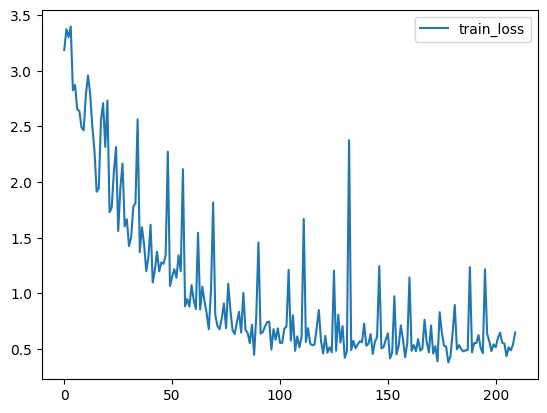

In [26]:
train_loss_count
plt.figure('Loss')
plt.plot(train_loss_count,label='train_loss')
plt.legend()
plt.show()

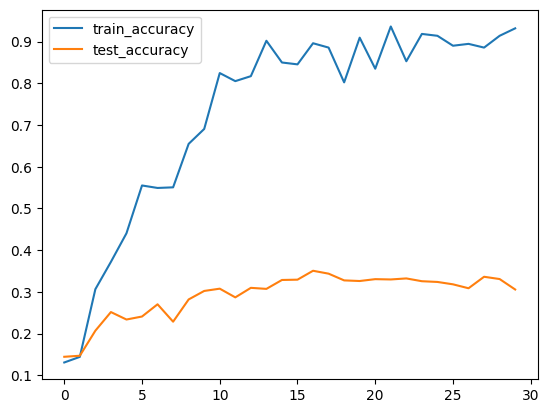

In [28]:
plt.figure('PyTorch_CNN_Loss')
plt.plot(train_acc_count,label='train_accuracy')
plt.plot(test_acc_count,label='test_accuracy')
plt.legend()
plt.show()

In [35]:
test_mean = np.mean(test_acc_count[20:])
print(test_mean)

0.32507440476190474


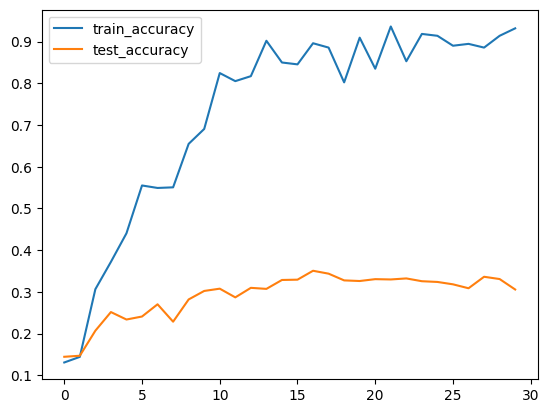

In [27]:
plt.figure('PyTorch_CNN_Loss')
plt.plot(train_acc_count,label='train_accuracy')
plt.plot(test_acc_count,label='test_accuracy')
plt.legend()
plt.show()

In [37]:
test_mean = np.mean(test_acc_count[20:])
print(test_mean)

0.32507440476190474


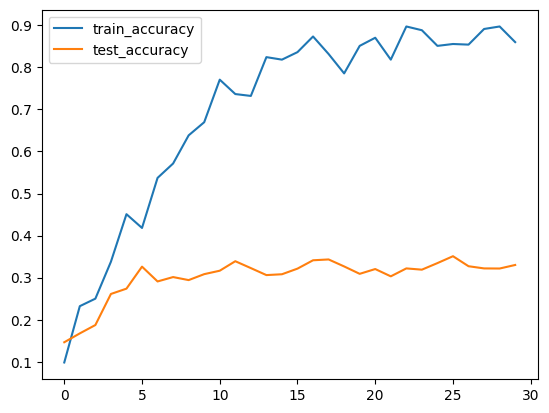

In [38]:
plt.figure('PyTorch_CNN_Loss')
plt.plot(train_acc_count,label='train_accuracy')
plt.plot(test_acc_count,label='test_accuracy')
plt.legend()
plt.show()

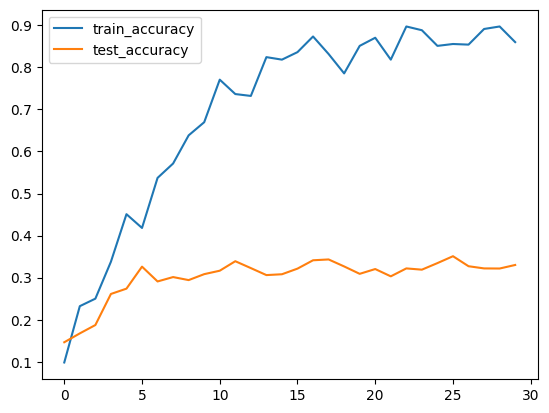

In [39]:
plt.figure('PyTorch_CNN_Loss')
plt.plot(train_acc_count,label='train_accuracy')
plt.plot(test_acc_count,label='test_accuracy')
plt.legend()
plt.show()